Import Libaries

In [1]:
import numpy as np
import cv2 as cv2
from mss import mss
from PIL import Image, ImageEnhance, ImageOps
import keyboard
import time
import tqdm as tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf                                                               
import random
from tqdm import tqdm
from tensorflow.keras.models import model_from_json

The Following Code Block is the Agent Class. It consists of the Convolutional NN that is the brains of the AI. It also contains the pretrained weights

In [2]:
class Agent:
    def __init__(self):
        #This is the actual Neural net
        model = Sequential([ 
            Conv2D(32, (8,8), input_shape=(76, 384, 4),
                   strides=(2,2), activation='relu'),
            MaxPooling2D(pool_size=(5,5), strides=(2, 2)),
            Conv2D(64, (4,4), activation='relu', strides=(1,1)),
            MaxPooling2D(pool_size=(7, 7), strides=(3, 3)),
            Conv2D(128, (1, 1), strides=(1,1), activation='relu'),
            MaxPooling2D(pool_size=(3,3), strides=(3,3)),
            Flatten(),
            Dense(384, activation='relu'),
            Dense(64, activation="relu", name="layer1"),
            Dense(8, activation="relu", name="layer2"),
            Dense(3, activation="linear", name="layer3"),
        ])
        #pick your learning rate here
        model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0001)) 
        #This is where you import your pretrained weights
        #model.load_weights("DinoGameSpeed4.h5")
        self.model = model
        self.memory = []
        # Print the model summary if you want to see what it looks like
        # print(self.model.summary()) 
        self.xTrain = []
        self.yTrain = []
        self.loss = []
        self.location = 0


    def predict(self, state):
        stateConv = state
        qval = self.model.predict(np.reshape(stateConv, (1, 76, 384, 4)))
        return qval

    def act(self, state):
        qval = self.predict(state)
        #you can either pick softmax or epislon greedy actions.
        #To pick Softmax, un comment the bottom 2 lines and delete everything below that 
        # prob = tf.nn.softmax(tf.math.divide((qval.flatten()), 1)) 
        # action = np.random.choice(range(3), p=np.array(prob))

        #Epsilon-Greedy actions->
        z = np.random.random()
        epsilon = 0.004
        if self.location > 1000:
            epsilon = 0.05
        epsilon = 0
        if z > epsilon:
            return np.argmax(qval.flatten())
        else:
            return np.random.choice(range(3))
        return action

    # This function stores experiences in the experience replay
    def remember(self, state, nextState, action, reward, done, location):
        self.location = location
        self.memory.append(np.array([state, nextState, action, reward, done]))

    #This is where the AI learns
    def learn(self):
        #Feel free to tweak this. This number is the number of experiences the AI learns from every round
        self.batchSize = 256 

        #If you don't trim the memory, your GPU might run out of memory during training. 
        #I found 35000 works well
        if len(self.memory) > 35000:
            self.memory = []
            print("trimming memory")
        if len(self.memory) < self.batchSize:
            print("too little info")
            return  
        batch = random.sample(self.memory, self.batchSize)

        self.learnBatch(batch)

    #The alpha value determines how future oriented the AI is.
    #bigger number (up to 1) -> more future oriented
    def learnBatch(self, batch, alpha=0.9):
        batch = np.array(batch)
        actions = batch[:, 2].reshape(self.batchSize).tolist()
        rewards = batch[:, 3].reshape(self.batchSize).tolist()

        stateToPredict = batch[:, 0].reshape(self.batchSize).tolist()
        nextStateToPredict = batch[:, 1].reshape(self.batchSize).tolist()

        statePrediction = self.model.predict(np.reshape(
            stateToPredict, (self.batchSize, 76, 384, 4)))
        nextStatePrediction = self.model.predict(np.reshape(
            nextStateToPredict, (self.batchSize, 76, 384, 4)))
        statePrediction = np.array(statePrediction)
        nextStatePrediction = np.array(nextStatePrediction)

        for i in range(self.batchSize):
            action = actions[i]
            reward = rewards[i]
            nextState = nextStatePrediction[i]
            qval = statePrediction[i, action]
            if reward < -5: 
                statePrediction[i, action] = reward
            else:
                #this is the q learning update rule
                statePrediction[i, action] += alpha * (reward + 0.95 * np.max(nextState) - qval)

        self.xTrain.append(np.reshape(
            stateToPredict, (self.batchSize, 76, 384, 4)))
        self.yTrain.append(statePrediction)
        history = self.model.fit(
            self.xTrain, self.yTrain, batch_size=5, epochs=1, verbose=0)
        loss = history.history.get("loss")[0]
        print("LOSS: ", loss)
        self.loss.append(loss)
        self.xTrain = []
        self.yTrain = []

Next we have the enviornment classs. This interacts with the actual chrome dino game and gathers screenshots for us. It then analyzes the screenshots and determines when the game is done. Make sure to tweak your screenshot view port in the __init__ function

In [3]:

class Enviornment:
    def __init__(self):
        ########
        #these are some various screenshot parameters that I found worked well for different resolutions
        #Use it as a starting point but use the open cv code snippets below to tweak your screenshot window
        # Do note that the lower the resolution you use, the faster the code runs
        # I saw a 200% screenshot framerate increase from dropping my screen resolution from 4k to 720p

        self.mon = {'top': 243, 'left': 0, 'width': 1366, 'height': 270} # 720p resolution
        # self.mon = {'top': 380, 'left': 0, 'width': 1920, 'height': 380} #1080p resolution
        # self.mon = {'top': 1000, 'left': 0, 'width': 3840, 'height': 760} #4k resolution
        ########
        
        self.sct = mss()
        self.counter = 0
        self.startTime = -1
        self.imageBank = []
        self.imageBankLength = 4 #number of frames for the conv net
        self.actionMemory = 2 #init as 2 to show no action taken   
        #image processing
        self.ones = np.ones((76,384,4))
        self.zeros = np.zeros((76,384,4))  
        self.zeros1 = np.zeros((76,384,4))
        self.zeros2 = np.zeros((76,384,4))
        self.zeros3 = np.zeros((76,384,4))
        self.zeros4 = np.zeros((76,384,4))
        self.zeros1[:,:,0] = 1
        self.zeros2[:,:,1] = 1
        self.zeros3[:,:,2] = 1
        self.zeros4[:,:,3] = 1

    def startGame(self):
        #start the game, giving the user a few seconds to click on the chrome tab after starting the code
        for i in reversed(range(3)):
            print("game starting in ", i)
            time.sleep(1)

    def step(self, action):        
        actions ={
            0: 'space',
            1: 'down'
        }            
        if action != self.actionMemory:
            if self.actionMemory != 2:
                keyboard.release(actions.get(self.actionMemory))
            if action != 2:
                keyboard.press(actions.get(action))
        self.actionMemory = action

        #This is where the screenshot happens
        screenshot = self.sct.grab(self.mon)
        img = np.array(screenshot)[:, :, 0]
        processedImg = self._processImg(img)
        state = self._imageBankHandler(processedImg)
        done = self._done(processedImg)
        reward = self._getReward(done)
        return state, reward, done

    def reset(self):
        self.startTime = time.time()
        keyboard.press("space")
        time.sleep(0.5)
        keyboard.release("space")
        return self.step(0)

    def _processImg(self, img):
        img = Image.fromarray(img)
        img = img.resize((384, 76), Image.ANTIALIAS)
        if np.sum(img) > 2000000:
            img = ImageOps.invert(img)
        img = self._contrast(img)

        #You can use the following open CV code segment to test your in game screenshots
        # cv2.imshow("image",img)
        # if cv2.waitKey(25) & 0xFF == ord('q'): 
        #     cv2.destroyAllWindows()
        
        img = np.reshape(img, (76,384))
        return img

    def _contrast(self,pixvals):
        minval = 32 #np.percentile(pixvals, 2)
        maxval = 171 #np.percentile(pixvals, 98)
        pixvals = np.clip(pixvals, minval, maxval)
        pixvals = ((pixvals - minval) / (maxval - minval))
        return pixvals

    def _imageBankHandler(self, img):
        img = np.array(img)
        while len(self.imageBank) < (self.imageBankLength): 
            self.imageBank.append(np.reshape(img,(76,384,1)) * self.ones)

        
        bank = np.array(self.imageBank)
        toReturn = self.zeros
        img1 = (np.reshape(img,(76,384,1)) * self.ones)  * self.zeros1
        img2 = bank[0] * self.zeros2
        img3 = bank[1] * self.zeros3
        img4 = bank[2] * self.zeros4


        toReturn = np.array(img1 + img2 + img3 + img4)        

        self.imageBank.pop(0)
        self.imageBank.append(np.reshape(img,(76 ,384,1)) * self.ones)

        return toReturn

    def _getReward(self,done):
        if done:
            return -15
        else: 
            return 1
            return time.time() - self.startTime
        
    def _done(self,img):
        img = np.array(img)
        img  = img[30:50, 180:203]


        val = np.sum(img)
        #Sum of the reset pixels when the game ends in the night mode
        expectedVal = 230.29258992805757
        #Sum of the reset pixels when the game ends in the day mode
        expectedVal2 = 318.6978417266187

        # This method checks if the game is done by reading the pixel values
        # of the area of the screen at the reset button. Then it compares it to
        # a pre determined sum. You might need to fine tune these values since each
        # person's viewport will be different. use the following print statements to 
        # help you find the appropirate values for your use case 

        # print("val: ", val)
        # print("Difference1: ", np.absolute(val-expectedVal2))
        # print("Difference2: ", np.absolute(val-expectedVal))
        if np.absolute(val-expectedVal) > 15 and np.absolute(val-expectedVal2) > 15: #seems to work well
            return False
        return True

Lastly we have the learning loop. Here the Agent/AI is created, the enviornment wrapper is made, and then the AI plays the game. To actually start the game, make sure run this and then click on the chrome dinosaur game. The code gives you a 3 second (adjustable) buffer between the code starting and you shifting to the chrome game. This needs to be done since the AI is not in direct control of the chrome game but rather controlling it via emulating keyboard strokes

In [4]:
plotX = []
while True:
    agent = Agent() #currently agent is configured with only 2 actions
    env = Enviornment()
    env.startGame()    
    #3500 refers to the number of episodes/iterations of the game to play
    for i in tqdm(range(3500)): 
        state, reward, done = env.reset()
        epReward = 0
        done = False
        episodeTime = time.time()
        stepCounter = 0
        while not done:
            action = agent.act(state)
            nextState, reward, done = env.step(action)
            ########
            #This next section is storing more memory of later parts of the game since 
            #if you don't do this, most of the experience replay fills up with the 
            #starting parts of the game since its played more often. A more elegant 
            #approach to this is "Prioritized experience replay" but this is an effective
            #alternative too
            if stepCounter> 700:
                for _ in range(5):
                    agent.remember(state, nextState, action, reward, done, stepCounter)
            elif stepCounter> 40:
                agent.remember(state, nextState, action, reward, done, stepCounter)                
            if done == True: #game ended
                for _ in range(10):
                    agent.remember(state, nextState, action, reward, done, stepCounter)
                print("breaking")
                break
            ########
            state = nextState
            stepCounter += 1
            epReward += reward

        #post episode
        if stepCounter != 0:
            print("Avg Frame-Rate: ", 1/((time.time()-episodeTime)/stepCounter))
        plotX.append(epReward)
        print(epReward)
        agent.learn()


       
        if i % 20 == 0:
            agent.model.save_weights ("DinoGameSpeed4.h5")
            print( "Saved model to disk")

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'DinoGameSpeed4.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

This next section plots the AI's total reward and the Nueral net learning loss for the AI as a function of the episode number

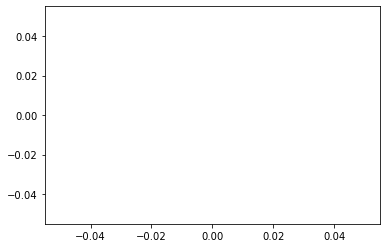

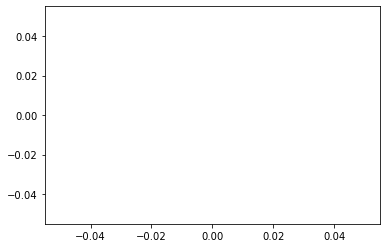

In [ ]:
plt.plot(range(len(plotX)),plotX) 
plt.show()
plt.plot(range(len(agent.loss)), agent.loss) 
plt.show() 